In [22]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.linear_model import Lasso
from collections import defaultdict
from tqdm.notebook import tqdm


In [23]:
# Styblinski-Tang 関数の定義 (入力次元 d で、効果を与えるのは先頭の 5 次元のみ)
def styblinski_tang(x, noise_std=0.1):
    """
    x: shape (..., d) の torch.Tensor。ここでは d >= 5 と仮定。
       目的関数は x の先頭 5 次元のみ利用し、それぞれについて
         f(x_j) = 0.5*(x_j^4 - 16*x_j^2 + 5*x_j)
       と定義し、全体は各次元の和とする。
    noise_std: ノイズの標準偏差
    """
    # 効果を与える次元（ここでは先頭5次元）
    effective = x[..., :5]
    # 各次元ごとに Styblinski-Tang の値を計算し、次元方向に sum する
    result = 0.5 * (effective**4 - 16 * effective**2 + 5 * effective)
    result_sum = torch.sum(result, dim=-1)
    noise = torch.randn_like(result_sum) * noise_std
    return result_sum + noise

In [24]:
# 2次元や3次元での可視化用関数（例として、先頭2次元のみでプロット）
def plot_styblinski_tang_2d(bounds=(-5, 5), N=100, noise_std=0.0):
    x_lin = np.linspace(bounds[0], bounds[1], N)
    y_lin = np.linspace(bounds[0], bounds[1], N)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
    xy = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    # 2次元プロットのため、入力は 2 次元だけでなく、100 次元のうち先頭2軸を使い、
    # 他はゼロとする（またはランダムでもよいが、ここでは見やすさのためゼロ）
    d = 100
    X_full = np.zeros((xy.shape[0], d))
    X_full[:, :2] = xy  # 先頭2次元のみ使う
    X_full = torch.tensor(X_full, dtype=torch.float32)
    Z = styblinski_tang(X_full, noise_std=noise_std).reshape(N, N).detach().numpy()
    plt.figure(figsize=(6, 5))
    cs = plt.contourf(X_grid, Y_grid, Z, levels=30, cmap='jet')
    plt.colorbar(cs)
    plt.title("Styblinski-Tang (有効次元: 先頭5次元, 2次元プロジェクション)")
    plt.xlabel("x0")
    plt.ylabel("x1 (その他は固定)")
    plt.axis("equal")
    plt.show()

In [25]:
def plot_styblinski_tang_3d(bounds=(-5, 5), N=100, noise_std=0.0):
    from mpl_toolkits.mplot3d import Axes3D
    x_lin = np.linspace(bounds[0], bounds[1], N)
    y_lin = np.linspace(bounds[0], bounds[1], N)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
    xy = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    d = 100
    X_full = np.zeros((xy.shape[0], d))
    X_full[:, :2] = xy
    X_full = torch.tensor(X_full, dtype=torch.float32)
    Z = styblinski_tang(X_full, noise_std=noise_std).reshape(N, N).detach().numpy()
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X_grid, Y_grid, Z, cmap='jet', rstride=2, cstride=2, alpha=0.8)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title("Styblinski-Tang 3D Surface (2次元プロジェクション)")
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    ax.set_zlabel("f(x)")
    plt.tight_layout()
    plt.show()

In [26]:
# グローバル最適値 (各有効次元の最適解が -39.16599 とすると、5次元では合計 -195.83)
global_optimum = -39.16599 * 5

In [27]:
# Sparse-OFUL with UCB-based Dimension Selection アルゴリズム
class SparseOFULBandit:
    def __init__(self, d, lambda_reg=1.0, lambda_lasso=0.1, tau=1e-3, beta_const=1.0, noise_std=0.1):
        """
        d: 入力次元
        lambda_reg: リッジ回帰の正則化パラメータ（UCB用の V 行列に用いる）
        lambda_lasso: Lassoの正則化パラメータ
        tau: スパース推定後の閾値
        beta_const: UCBのスケール定数
        noise_std: 目的関数評価時のノイズ標準偏差（目的関数内部で使用）
        """
        self.d = d
        self.lambda_reg = lambda_reg
        self.lambda_lasso = lambda_lasso
        self.tau = tau
        self.beta_const = beta_const
        self.noise_std = noise_std

        # 初期化データセット (リスト形式)
        self.X_data = []
        self.Y_data = []
        # UCB用の正則化行列 (低次元空間で更新するが初期値は全体 d 次元)
        self.V = self.lambda_reg * np.eye(d)
        self.b = np.zeros(d)
        # 記録用
        self.arm_history = []  # 各ラウンドで選択したアームの元の特徴（d 次元）
        self.S_history = []    # 各ラウンドで抽出した重要次元集合
        self.eval_history = [] # 各ラウンドでの最良評価値
        # 選択された方向の絶対値の累積 (d 次元)
        self.direction_sum_abs = np.zeros(d)

    def initialize(self, X_init, Y_init):
        """初期サンプルをセット"""
        self.X_data = X_init.copy()  # (n0, d) の numpy 配列
        self.Y_data = Y_init.copy()  # (n0, ) の numpy 配列
        self.best_value = np.min(Y_init)
        self.best_x = X_init[np.argmin(Y_init)]
        self.eval_history.append(self.best_value)

    def lasso_regression(self):
        """現在のデータから Lasso によりパラメータ推定"""
        X = np.array(self.X_data)
        Y = np.array(self.Y_data)
        model = Lasso(alpha=self.lambda_lasso, fit_intercept=False, max_iter=10000)
        model.fit(X, Y)
        theta_hat = model.coef_
        return theta_hat

    def select_important_dims(self, theta_hat):
        """Lasso推定結果から重要次元集合 S を抽出 (閾値 tau 以上の次元)"""
        S = np.where(np.abs(theta_hat) >= self.tau)[0]
        if len(S) == 0:
            # すべての成分が閾値未満の場合は、最低1つは選択（例えば最大値の次元）
            S = np.array([np.argmax(np.abs(theta_hat))])
        return S

    def update_UCB_matrices(self, x, S):
        """選択されたアーム x (d 次元) の S 部分を用いて UCB の V, b を更新"""
        x_S = x[S].reshape(-1, 1)
        self.V[np.ix_(S, S)] += x_S @ x_S.T
        # b の更新は、報酬改善に依存させるが、ここではシンプルに選択した x を加算
        self.b[S] += x[S]

    def compute_UCB(self, x, theta_hat, S, t):
        """
        x: 評価するアーム (d 次元 numpy array)
        theta_hat: Lasso推定による全体 d 次元の推定値
        S: 重要次元のインデックス
        t: 現在のラウンド番号
        """
        # 低次元サブスペースにおける推定値
        theta_S = theta_hat[S]
        x_S = x[S]
        # UCBの信頼区間項
        # V_S = lambda_reg*I + Σ x_i_S x_i_S^T を使うが、ここでは近似的に
        V_S = self.V[np.ix_(S, S)]
        try:
            V_S_inv = np.linalg.inv(V_S)
        except np.linalg.LinAlgError:
            V_S_inv = np.linalg.pinv(V_S)
        uncertainty = self.beta_const * np.sqrt(x_S.T @ V_S_inv @ x_S * np.log(t+1))
        ucb = x_S.T @ theta_S + uncertainty
        return ucb

    def select_arm(self, candidate_arms, theta_hat, S, t):
        """
        candidate_arms: (n_candidate, d) の候補アーム群 (ここではランダム生成)
        theta_hat: Lasso 推定値
        S: 重要次元集合
        t: 現在のラウンド番号
        """
        best_ucb = -np.inf
        best_arm = None
        best_arm_idx = -1
        for i, x in enumerate(candidate_arms):
            ucb = self.compute_UCB(x, theta_hat, S, t)
            if ucb > best_ucb:
                best_ucb = ucb
                best_arm = x
                best_arm_idx = i
        return best_arm, best_arm_idx

    def run_round(self, candidate_arms, t):
        """
        1 ラウンドの実行:
          - Lasso によるパラメータ推定
          - 重要次元 S の抽出
          - 候補アーム群から UCB に基づき最良アームを選択
          - 選択したアームで目的関数評価
          - UCB更新、記録
        """
        theta_hat = self.lasso_regression()
        S = self.select_important_dims(theta_hat)
        self.S_history.append(S)
        best_arm, arm_idx = self.select_arm(candidate_arms, theta_hat, S, t)
        # 評価: styblinski_tang 関数 (0次元目のみ寄与する)
        x_tensor = torch.tensor(best_arm.reshape(1, -1), dtype=torch.float32)
        y = styblinski_tang(x_tensor, noise_std=self.noise_std).item()
        # 記録
        self.X_data.append(best_arm)
        self.Y_data.append(y)
        if y < self.best_value:
            self.best_value = y
            self.best_x = best_arm.copy()
        self.eval_history.append(self.best_value)
        self.arm_history.append(best_arm)
        # UCB マトリクスの更新（重要次元部分のみ）
        self.update_UCB_matrices(best_arm, S)
        # 選択したアーム（方向）の絶対値を累積
        self.direction_sum_abs += np.abs(best_arm)
        return best_arm, y, S

    def optimize(self, n_rounds, n_candidate=10):
        """
        n_rounds: 最適化ラウンド数
        n_candidate: 各ラウンドでランダムに生成する候補アームの数
        """
        for t in range(1, n_rounds+1):
            # 候補アームは一様乱数で生成 (bounds は [-5, 5] とする)
            candidate_arms = np.random.uniform(-5, 5, size=(n_candidate, self.d))
            self.run_round(candidate_arms, t)
        return self.best_x, self.best_value

In [28]:
# 従来のシンプルなバンディット（ECI_BO_Bandit風）の実装（ここでは UCB による単純な線形バンディットとして実装）
class SimpleLinUCBBandit:
    def __init__(self, d, lambda_reg=1.0, alpha=1.0, noise_std=0.1):
        self.d = d
        self.lambda_reg = lambda_reg
        self.alpha = alpha
        self.noise_std = noise_std
        self.V = lambda_reg * np.eye(d)
        self.b = np.zeros(d)
        self.X_data = []
        self.Y_data = []
        self.eval_history = []
        self.arm_history = []

    def initialize(self, X_init, Y_init):
        self.X_data = X_init.copy()
        self.Y_data = Y_init.copy()
        self.best_value = np.min(Y_init)
        self.best_x = X_init[np.argmin(Y_init)]
        self.eval_history.append(self.best_value)

    def update(self, x, y):
        self.X_data.append(x)
        self.Y_data.append(y)
        self.V += np.outer(x, x)
        self.b += x * y
        if y < self.best_value:
            self.best_value = y
            self.best_x = x.copy()
        self.eval_history.append(self.best_value)

    def select_arm(self, candidate_arms, t):
        # パラメータ推定（リッジ回帰風に）
        theta = np.linalg.inv(self.V) @ self.b
        best_ucb = -np.inf
        best_arm = None
        best_arm_idx = -1
        for i, x in enumerate(candidate_arms):
            x = x.reshape(-1)
            x = x.flatten()
            # UCB値: 推定値と不確実性
            uncertainty = self.alpha * math.sqrt(x.T @ np.linalg.inv(self.V) @ x * math.log(t+1))
            ucb = x.T @ theta + uncertainty
            if ucb > best_ucb:
                best_ucb = ucb
                best_arm = x
                best_arm_idx = i
        return best_arm, best_arm_idx

    def optimize(self, n_rounds, n_candidate=10):
        for t in range(1, n_rounds+1):
            candidate_arms = np.random.uniform(-5, 5, size=(n_candidate, self.d))
            best_arm, idx = self.select_arm(candidate_arms, t)
            x_tensor = torch.tensor(best_arm.reshape(1, -1), dtype=torch.float32)
            y = styblinski_tang(x_tensor, noise_std=self.noise_std).item()
            self.update(best_arm, y)
            self.arm_history.append(best_arm)
        return self.best_x, self.best_value

In [29]:
# 初期点生成関数
def generate_initial_points(n_initial, d, bounds=(-5,5)):
    return np.random.uniform(bounds[0], bounds[1], size=(n_initial, d))

In [30]:
# 実験のパラメータ設定
d = 100         # 100次元
n_initial = 200
n_rounds = 500 # 各 run のラウンド数
n_runs = 20    # 試行回数


# 結果記録用
sparse_history_all = []
simple_history_all = []
sparse_bandits = []
simple_bandits = []
arm_selection_sparse = []
arm_selection_simple = []

# tqdm での進捗表示
for run in tqdm(range(n_runs), desc="Runs"):
    # 初期点生成
    X_init = generate_initial_points(n_initial, d)
    # styblinski_tang 関数の評価（各サンプルごと）
    Y_init = np.array([styblinski_tang(torch.tensor(x.reshape(1, -1), dtype=torch.float32), noise_std=0.1).item() for x in X_init])

    # Sparse-OFUL バンディット
    sparse_bandit = SparseOFULBandit(d, lambda_reg=1.0, lambda_lasso=0.1, tau=0.05, beta_const=1.0, noise_std=0.1)
    sparse_bandit.initialize(X_init.tolist(), Y_init.tolist())
    best_x_sparse, best_val_sparse = sparse_bandit.optimize(n_rounds, n_candidate=20)

    # SimpleLinUCB バンディット
    simple_bandit = SimpleLinUCBBandit(d, lambda_reg=1.0, alpha=1.0, noise_std=0.1)
    simple_bandit.initialize(X_init.tolist(), Y_init.tolist())
    best_x_simple, best_val_simple = simple_bandit.optimize(n_rounds, n_candidate=20)

    sparse_history_all.append(sparse_bandit.eval_history)
    simple_history_all.append(simple_bandit.eval_history)
    sparse_bandits.append(sparse_bandit)
    simple_bandits.append(simple_bandit)
    arm_selection_sparse.append(sparse_bandit.arm_history)
    arm_selection_simple.append(simple_bandit.arm_history)


Runs:   0%|          | 0/20 [00:00<?, ?it/s]

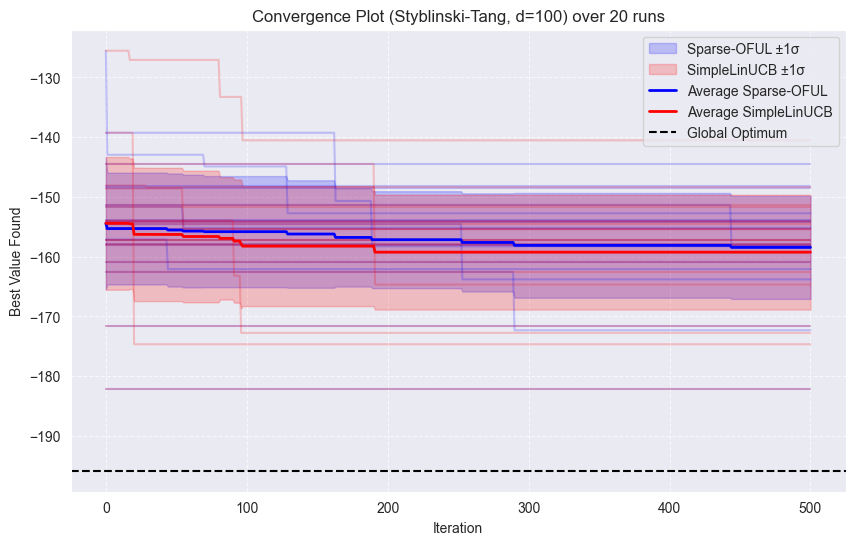

In [31]:
# 平均収束プロットの作成
def calculate_confidence_bands(histories):
    histories_array = np.array(histories)
    mean = np.mean(histories_array, axis=0)
    std = np.std(histories_array, axis=0)
    return mean, mean - std, mean + std

mean_sparse, lower_sparse, upper_sparse = calculate_confidence_bands(sparse_history_all)
mean_simple, lower_simple, upper_simple = calculate_confidence_bands(simple_history_all)

plt.figure(figsize=(10, 6))
for hist in sparse_history_all:
    plt.plot(hist, color='blue', alpha=0.2)
for hist in simple_history_all:
    plt.plot(hist, color='red', alpha=0.2)
plt.fill_between(range(len(mean_sparse)), lower_sparse, upper_sparse, color='blue', alpha=0.2, label='Sparse-OFUL ±1σ')
plt.fill_between(range(len(mean_simple)), lower_simple, upper_simple, color='red', alpha=0.2, label='SimpleLinUCB ±1σ')
plt.plot(mean_sparse, label="Average Sparse-OFUL", color='blue', linewidth=2)
plt.plot(mean_simple, label="Average SimpleLinUCB", color='red', linewidth=2)
plt.axhline(global_optimum, color='black', linestyle='--', label="Global Optimum")
plt.xlabel("Iteration")
plt.ylabel("Best Value Found")
plt.title(f"Convergence Plot (Styblinski-Tang, d={d}) over {n_runs} runs")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

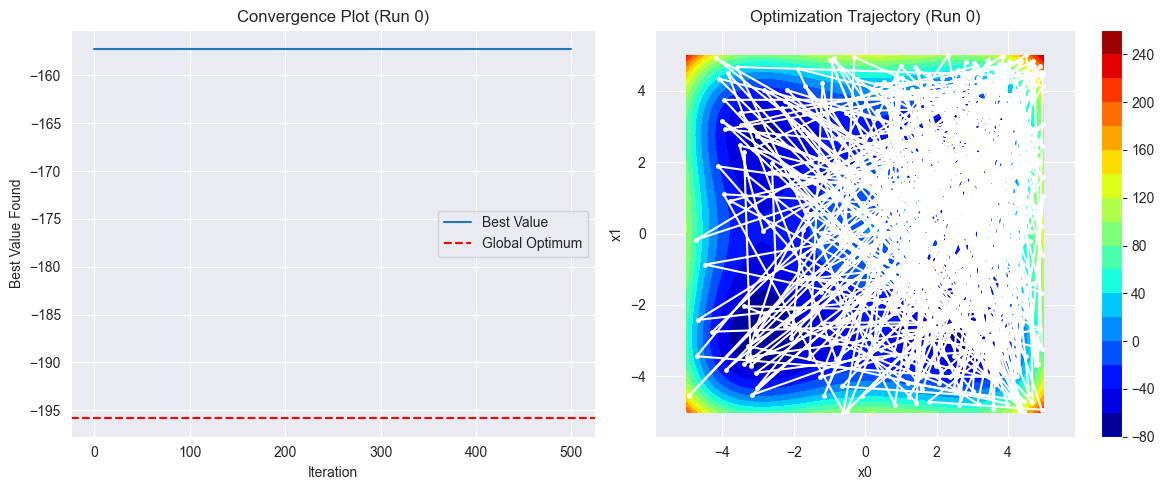

In [32]:
# 探索軌跡の可視化 (最初の run の結果例)
def plot_optimization_trajectory(bandit, run_index=0):
    N = 100
    x_lin = np.linspace(-5, 5, N)
    y_lin = np.linspace(-5, 5, N)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
    xy = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    xy_t = torch.tensor(xy, dtype=torch.float32)
    Z = styblinski_tang(xy_t, noise_std=0.0).reshape(N, N).detach().numpy()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(bandit.eval_history, label="Best Value")
    plt.axhline(global_optimum, color='r', linestyle='--', label='Global Optimum')
    plt.xlabel("Iteration")
    plt.ylabel("Best Value Found")
    plt.legend()
    plt.title("Convergence Plot (Run {})".format(run_index))

    plt.subplot(1, 2, 2)
    cs = plt.contourf(X_grid, Y_grid, Z, levels=20, cmap='jet')
    plt.colorbar(cs)
    plt.title("Optimization Trajectory (Run {})".format(run_index))
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.axis("equal")
    points = np.array(bandit.arm_history)
    plt.plot(points[:,0], points[:,1], 'w.-', markersize=5)
    plt.tight_layout()
    plt.show()

# 最初の run の結果例をプロット
plot_optimization_trajectory(sparse_bandits[0], run_index=0)

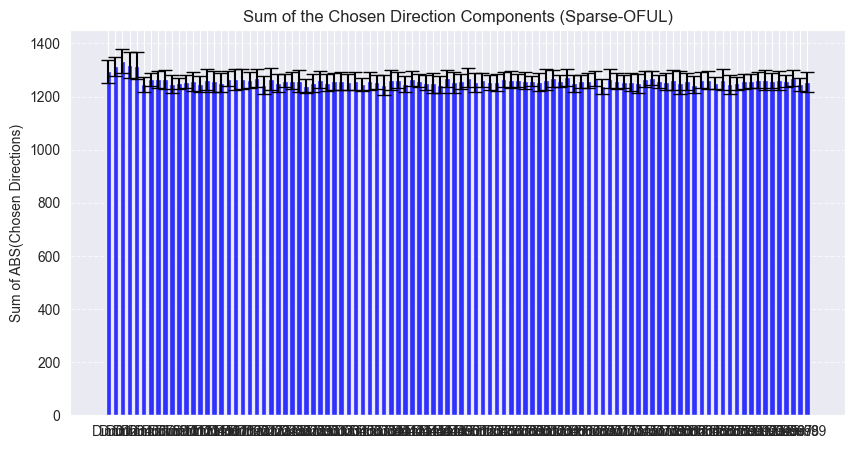

=== Sparse-OFUL: Sum of ABS(Chosen Directions) per run ===
Run 0:  Dim0=1411.864, Dim1=1316.674, Dim2=1310.338, Dim3=1364.142, Dim4=1385.344, Dim5=1269.644, Dim6=1244.154, Dim7=1280.103, Dim8=1282.647, Dim9=1304.037, Dim10=1256.580, Dim11=1242.991, Dim12=1243.503, Dim13=1216.341, Dim14=1259.638, Dim15=1294.680, Dim16=1215.985, Dim17=1258.778, Dim18=1320.240, Dim19=1328.274, Dim20=1305.966, Dim21=1198.088, Dim22=1199.049, Dim23=1272.295, Dim24=1244.397, Dim25=1296.997, Dim26=1266.668, Dim27=1228.055, Dim28=1237.636, Dim29=1227.850, Dim30=1271.409, Dim31=1202.107, Dim32=1320.382, Dim33=1280.585, Dim34=1270.564, Dim35=1276.797, Dim36=1235.617, Dim37=1329.961, Dim38=1300.000, Dim39=1163.962, Dim40=1248.623, Dim41=1299.842, Dim42=1250.885, Dim43=1279.023, Dim44=1201.171, Dim45=1306.407, Dim46=1264.232, Dim47=1278.231, Dim48=1304.705, Dim49=1211.865, Dim50=1270.907, Dim51=1265.385, Dim52=1240.617, Dim53=1278.114, Dim54=1249.585, Dim55=1308.642, Dim56=1213.872, Dim57=1295.794, Dim58=1225.013,

In [33]:
# 選択された方向（アーム）の集計・可視化
direction_sums_sparse = np.array([b.direction_sum_abs for b in sparse_bandits])
mean_dir_sparse = np.mean(direction_sums_sparse, axis=0)
std_dir_sparse  = np.std(direction_sums_sparse, axis=0)
x_labels = [f"Dim{i}" for i in range(d)]
x_pos = np.arange(len(x_labels))
plt.figure(figsize=(10, 5))
plt.bar(x_pos, mean_dir_sparse, yerr=std_dir_sparse, alpha=0.8, capsize=5, color='blue')
plt.xticks(x_pos, x_labels)
plt.ylabel("Sum of ABS(Chosen Directions)")
plt.title("Sum of the Chosen Direction Components (Sparse-OFUL)")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# 各 run 毎の値をテーブル表示
print("=== Sparse-OFUL: Sum of ABS(Chosen Directions) per run ===")
for i, ds in enumerate(direction_sums_sparse):
    print(f"Run {i}: ", ", ".join([f"Dim{j}={ds[j]:.3f}" for j in range(d)]))